In [73]:
import pickle
from os.path import join
import os
import re
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.linear_model import LinearRegression

In [74]:
data_dir = 'results'

In [75]:
# get all pickled results
paths = [join(data_dir, path) for path in os.listdir(data_dir) if 'all' not in path]

In [76]:
with open(paths[0], 'rb') as f:
    x = pickle.load(f)
x

{'num_bits': 512,
 'neural': {'num_pairs': 50, 'mae': 0.08838901308518876},
 'minhash': {'mae': 0.15530872937163753}}

In [77]:
# we need a dict with pairs then bit errors in net and sim
result = defaultdict(lambda: dict())

In [78]:
for filename in paths:
    pairs, bits = re.findall('\d+', filename)
    
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    
    result[pairs][bits] = {
        'neural_mae': data['neural']['mae'],
#         'neural_acc': data['neural']['acc_test'],
        'minhash_mae': data['minhash']['mae']
    }


In [79]:
result = dict(result)

In [112]:
def plot_results(data, num_pairs, smooth=False):

    x = sorted(data.keys(), key=int)
    
    plt.figure(int(num_pairs)+1)
    mae_minhash = [data[num_bit]['minhash_mae'] for num_bit in x]
    mae_neural = [data[num_bit]['neural_mae'] for num_bit in x]
    
    if smooth:
        # smooth neural net curve
        start, stop = mae_neural[0],  mae_neural[-1]
        mae_neural = gaussian_filter1d(mae_neural, sigma=1).tolist()
        mae_neural[0] = start
        mae_neural[-1] = stop

    plt.plot(x, mae_minhash, label='WeightedMinhash hashes')
    plt.plot(x, mae_neural, label='Model hashes')
    
    
    # lin reg for neural
    regression_model = LinearRegression()
    x_arr = np.array([int(val) for val in x ]).reshape(-1, 1)
    regression_model.fit(x_arr, mae_neural)
    y_predicted = regression_model.predict(x_arr)
    plt.plot(x, y_predicted, label='Hashes trend', linestyle='--')

    
    plt.title(f'MAE for {num_pairs} pairs.')
    plt.xlabel('Number of bits')
    plt.ylabel('MAE in similarity')
    plt.legend(loc='upper right')
    plt.savefig('minhash_neural_curve.png')
    
    plt.show()
    

In [113]:
# sorted_pairs = sorted(result.keys(), key=int)
# for num_pairs in sorted_pairs:
#     plot_results(result[num_pairs], num_pairs)

In [114]:
min_val = {
    'mae_neural': {'val': 1, 'num_bit': None, 'num_pairs': None},
    'mae_minhash': {'val': 1, 'num_bit': None, 'num_pairs': None}
}

In [115]:
for num_pairs in result.keys():
    for num_bit in result[num_pairs].keys():
        if result[num_pairs][num_bit]['neural_mae'] < min_val['mae_neural']['val']:
            min_val['mae_neural']['val'] = result[num_pairs][num_bit]['neural_mae']
            min_val['mae_neural']['num_bit'] = num_bit
            min_val['mae_neural']['num_pairs'] = num_pairs
        
        if result[num_pairs][num_bit]['minhash_mae'] < min_val['mae_minhash']['val']:
            min_val['mae_minhash']['val'] = result[num_pairs][num_bit]['minhash_mae']
            min_val['mae_minhash']['num_bit'] = num_bit
            min_val['mae_minhash']['num_pairs'] = num_pairs

In [116]:
min_val

{'mae_neural': {'val': 0.08838901308518876,
  'num_bit': '512',
  'num_pairs': '50'},
 'mae_minhash': {'val': 0.09225990744561571,
  'num_bit': '32',
  'num_pairs': '50'}}

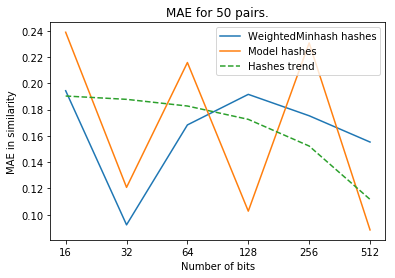

In [117]:
plot_results(result['50'], 50)

In [118]:
result['50']['32']

{'neural_mae': 0.12078463970745244, 'minhash_mae': 0.09225990744561571}

In [60]:
result['50']['512']

{'neural_mae': 0.08838901308518876, 'minhash_mae': 0.15530872937163753}